# Generate Temperature Sensor Data

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.signal import savgol_filter


In [57]:
# everything is [Celsius] OR [Meter]
base_elevation = 800
peak_elevation = 3000
# random winter day
date = datetime(2024, 1, 15)
# 5-minute timestamps
timestamps = pd.date_range(start=date, end=date + timedelta(days=1), freq='5min')[:-1]


In [59]:
def generate_smooth_temp(mean, amplitude, num_points):
    x = np.linspace(0, 2*np.pi, num_points)
    smooth_temp = mean + amplitude * np.sin(x - np.pi/2)
    noise = np.random.normal(0, 0.05, num_points)
    offset = np.random.uniform(-0.1, 0.1)
    return smooth_temp + noise + offset

def generate_wind_speed(num_points, base_speed, randomness):
    # Random Walk - https://people.duke.edu/~rnau/411rand.htm
    wind_speed = np.cumsum(np.random.normal(0, randomness, num_points))
    slow_variation = 5 * np.sin(np.linspace(0, 4*np.pi, num_points))
    wind_speed += slow_variation
    # 5% occasional gust
    gust_probability = 0.05
    # Bernoulli dist.
    gusts = np.random.choice([0, 1], size=num_points, p=[1-gust_probability, gust_probability])
    # Uniform dist.
    gust_strength = np.random.uniform(2, 5, num_points)
    wind_speed += gusts * gust_strength
    # wind speed > 0
    wind_speed = np.clip(wind_speed, 0, 30)
    # center around base_speed
    wind_speed += base_speed - np.mean(wind_speed)
    # smoothing - https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html
    wind_speed = savgol_filter(wind_speed, window_length=31, polyorder=3)

    return wind_speed

def apply_wind_chill(temp, wind_speed):
    return temp - 0.1 * wind_speed

def generate_day_data():
    num_points = len(timestamps)
    # initial temperatures
    base_temp = generate_smooth_temp(mean=-5, amplitude=3, num_points=num_points)
    peak_temp = generate_smooth_temp(mean=-15, amplitude=3, num_points=num_points)
    # wind speeds
    base_wind = generate_wind_speed(num_points, base_speed=12, randomness=1.5)
    peak_wind = generate_wind_speed(num_points, base_speed=20, randomness=2)
    # wind chill effect
    base_temp = apply_wind_chill(base_temp, base_wind)
    peak_temp = apply_wind_chill(peak_temp, peak_wind)

    return base_temp, peak_temp, base_wind, peak_wind


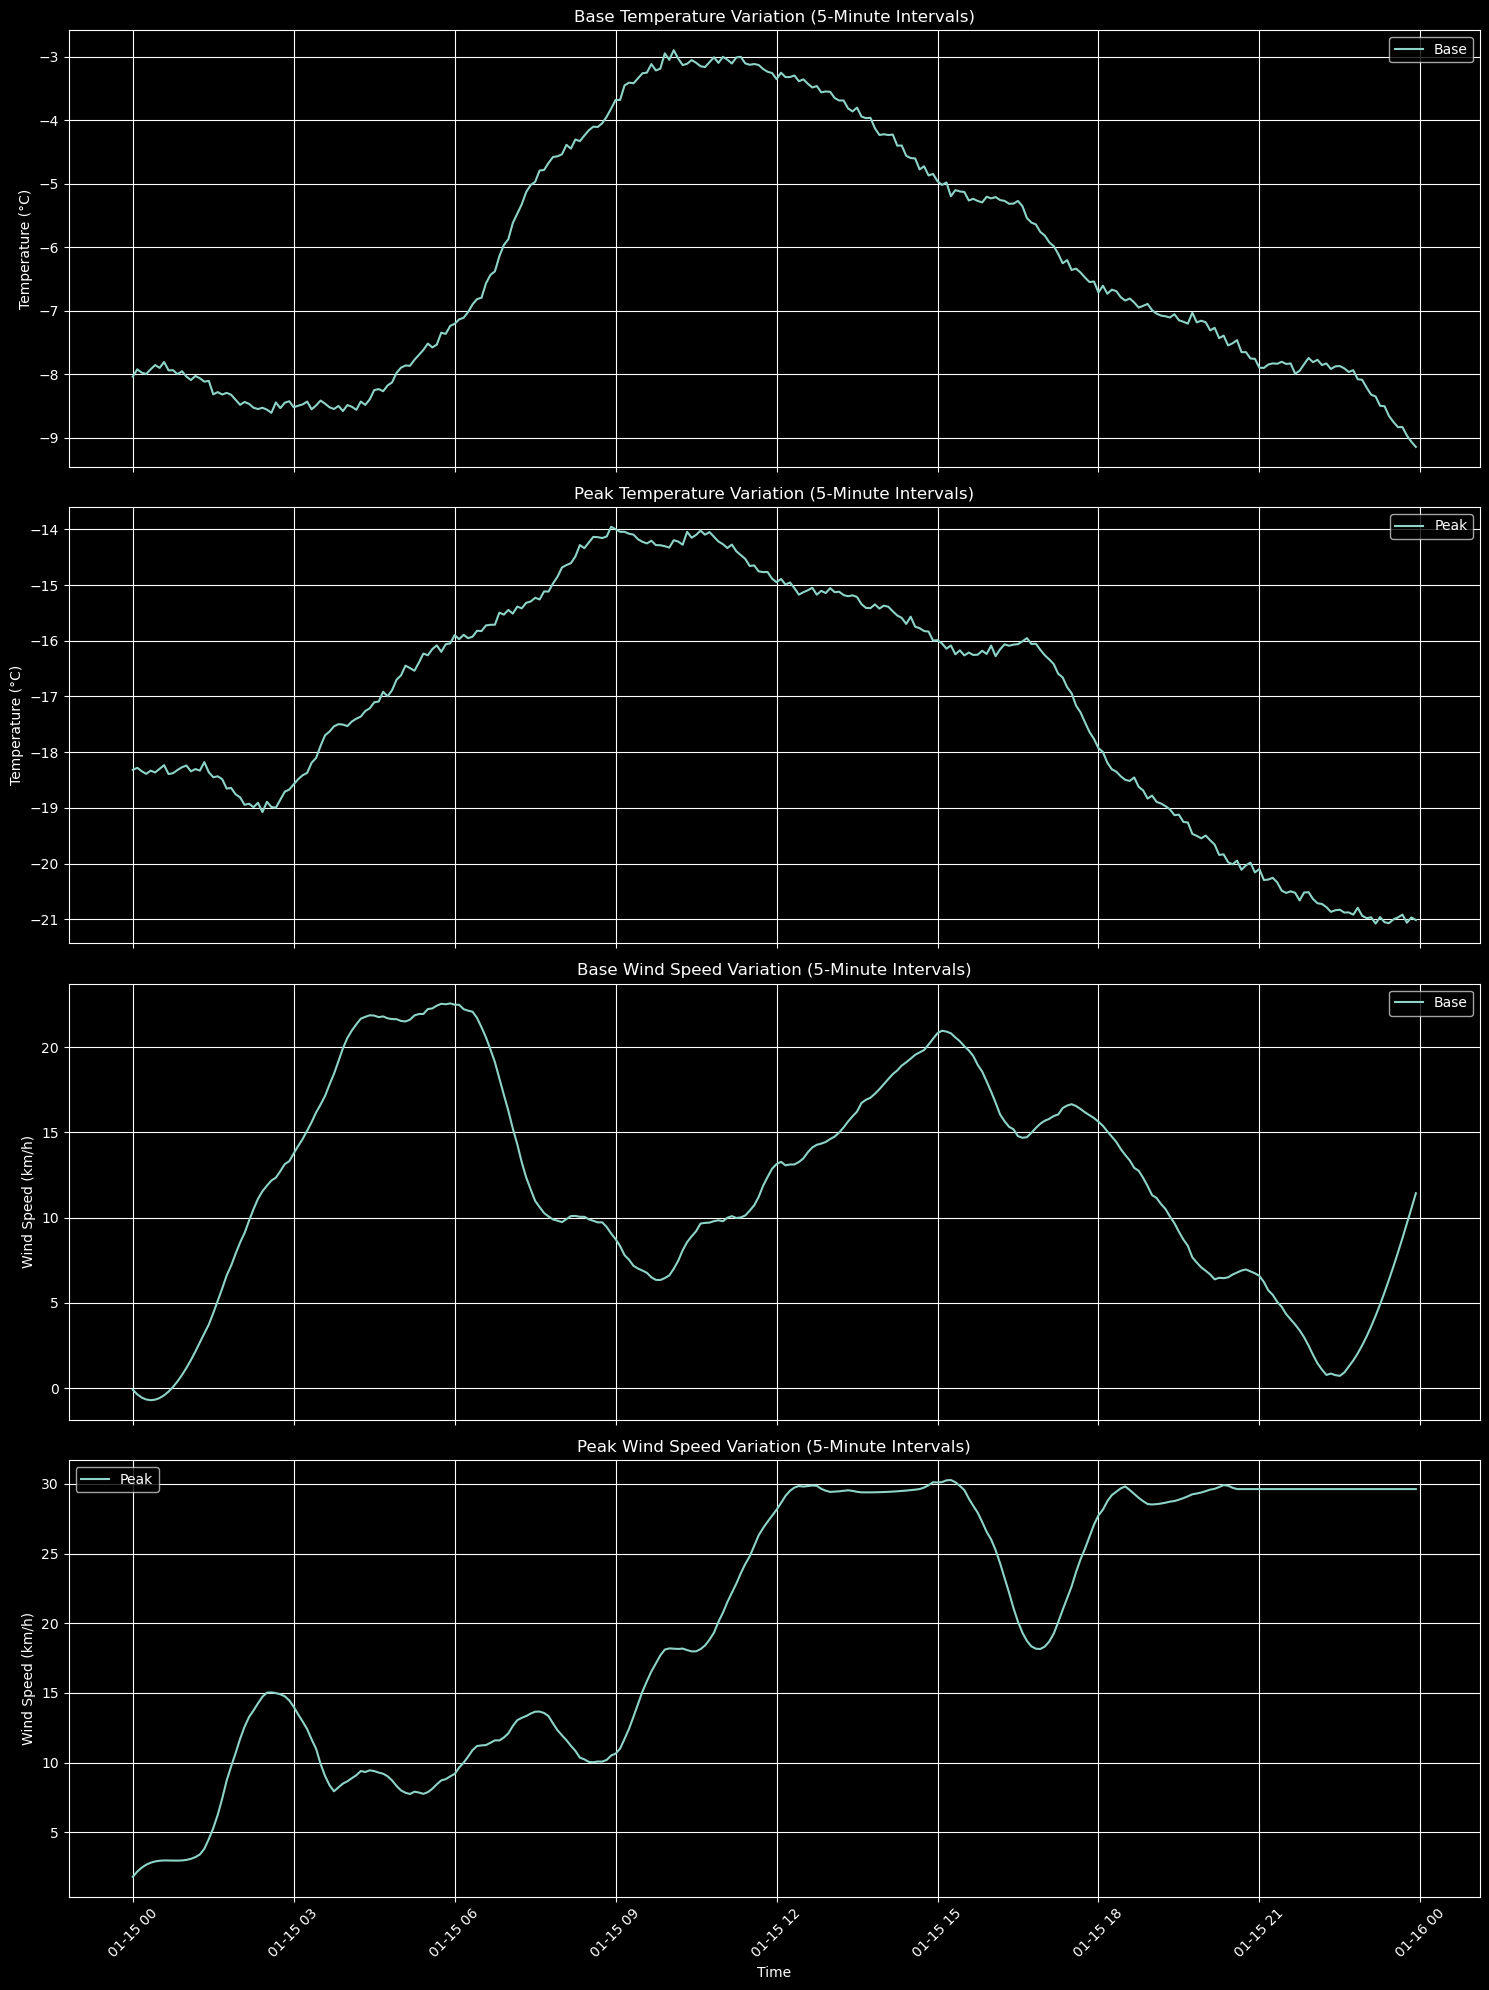

In [66]:
base_temp, peak_temp, base_wind, peak_wind = generate_day_data()

# seperate dataframes for temperature and wind speed
temp_df = pd.DataFrame({
    'Timestamp': timestamps,
    'Base Temperature [°C]': base_temp,
    'Peak Temperature [°C]': peak_temp
})

wind_df = pd.DataFrame({
    'Timestamp': timestamps,
    'Base Wind Speed [km/h]': base_wind,
    'Peak Wind Speed [km/h]': peak_wind
})

plt.style.use('dark_background')
fig, axs = plt.subplots(4, 1, figsize=(15, 20), sharex=True)
axs[0].plot(temp_df['Timestamp'], temp_df['Base Temperature [°C]'], label='Base')
axs[1].plot(temp_df['Timestamp'], temp_df['Peak Temperature [°C]'], label='Peak')
axs[2].plot(wind_df['Timestamp'], wind_df['Base Wind Speed [km/h]'], label='Base')
axs[3].plot(wind_df['Timestamp'], wind_df['Peak Wind Speed [km/h]'], label='Peak')
titles = ['Base Temperature', 'Peak Temperature', 'Base Wind Speed', 'Peak Wind Speed']
ylabels = ['Temperature (°C)', 'Temperature (°C)', 'Wind Speed (km/h)', 'Wind Speed (km/h)']
for ax, title, ylabel in zip(axs, titles, ylabels):
    ax.set_title(f'{title} Variation (5-Minute Intervals)')
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True)

axs[-1].set_xlabel('Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [69]:
temp_df.to_csv('temperatures.csv', index=False)
wind_df.to_csv('wind_speeds.csv', index=False)
print("Temperature data saved to 'temperatures.csv'")
print("Wind speed data saved to 'wind_speeds.csv'")

print("\n-------------------------Temperature Data-------------------------")
print(temp_df.describe())
print("\n-------------------------Wind Speed Data-------------------------")
print(wind_df.describe())


Temperature data saved to 'temperatures.csv'
Wind speed data saved to 'wind_speeds.csv'

-------------------------Temperature Data-------------------------
                 Timestamp  Base Temperature [°C]  Peak Temperature [°C]
count                  288             288.000000             288.000000
mean   2024-01-15 11:57:30              -6.207447             -17.091074
min    2024-01-15 00:00:00              -9.143913             -21.076543
25%    2024-01-15 05:58:45              -7.936345             -18.721665
50%    2024-01-15 11:57:30              -6.801619             -16.469344
75%    2024-01-15 17:56:15              -4.373993             -15.251581
max    2024-01-15 23:55:00              -2.898147             -13.955007
std                    NaN               1.945050               2.153177

-------------------------Wind Speed Data-------------------------
                 Timestamp  Base Wind Speed [km/h]  Peak Wind Speed [km/h]
count                  288              288.0

# Variation between runs

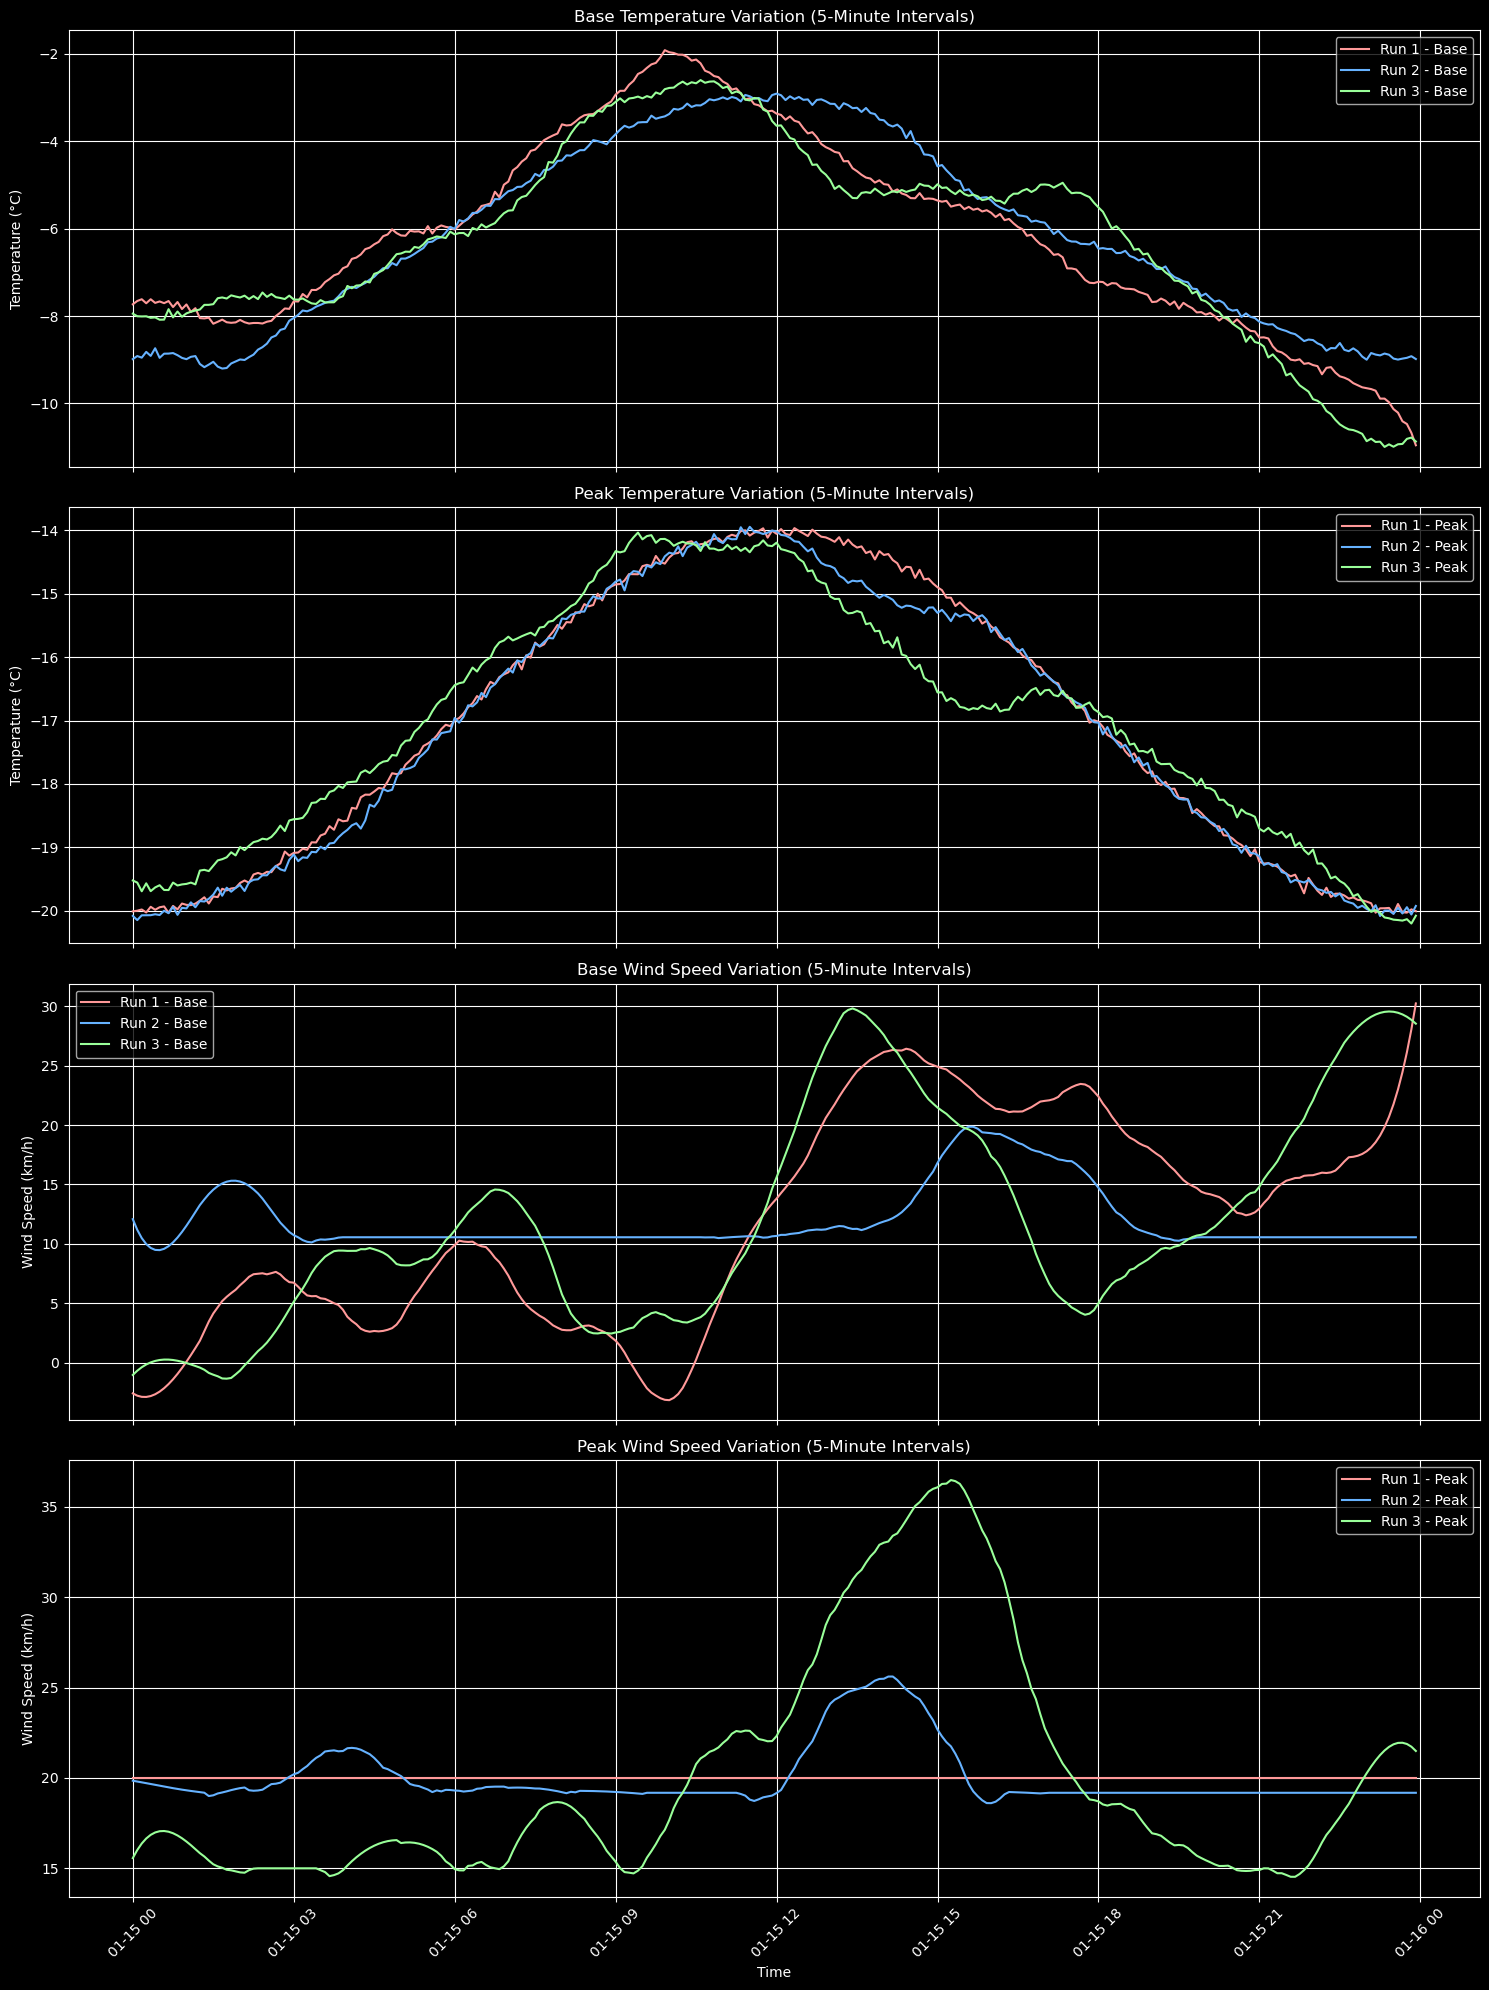

In [71]:
data_sets = []
for _ in range(3):
    np.random.seed()
    data_sets.append(generate_day_data())

temp_dfs = []
wind_dfs = []

for i, (base_temp, peak_temp, base_wind, peak_wind) in enumerate(data_sets):
    temp_df = pd.DataFrame({
        'Timestamp': timestamps,
        f'Base Temperature [°C] - Run {i+1}': base_temp,
        f'Peak Temperature [°C] - Run {i+1}': peak_temp
    })
    temp_dfs.append(temp_df)

    wind_df = pd.DataFrame({
        'Timestamp': timestamps,
        f'Base Wind Speed [km/h] - Run {i+1}': base_wind,
        f'Peak Wind Speed [km/h] - Run {i+1}': peak_wind
    })
    wind_dfs.append(wind_df)

temp_df_merged = pd.concat([df.set_index('Timestamp') for df in temp_dfs], axis=1).reset_index()
wind_df_merged = pd.concat([df.set_index('Timestamp') for df in wind_dfs], axis=1).reset_index()

plt.style.use('dark_background')
fig, axs = plt.subplots(4, 1, figsize=(15, 20), sharex=True)
colors = ['#FF9999', '#66B2FF', '#99FF99']
labels = ['Run 1', 'Run 2', 'Run 3']
for i in range(3):
    axs[0].plot(temp_df_merged['Timestamp'], temp_df_merged[f'Base Temperature [°C] - Run {i+1}'], color=colors[i], label=f'Run {i+1} - Base')
    axs[1].plot(temp_df_merged['Timestamp'], temp_df_merged[f'Peak Temperature [°C] - Run {i+1}'], color=colors[i], label=f'Run {i+1} - Peak')
    axs[2].plot(wind_df_merged['Timestamp'], wind_df_merged[f'Base Wind Speed [km/h] - Run {i+1}'], color=colors[i], label=f'Run {i+1} - Base')
    axs[3].plot(wind_df_merged['Timestamp'], wind_df_merged[f'Peak Wind Speed [km/h] - Run {i+1}'], color=colors[i], label=f'Run {i+1} - Peak')
titles = ['Base Temperature', 'Peak Temperature', 'Base Wind Speed', 'Peak Wind Speed']
ylabels = ['Temperature (°C)', 'Temperature (°C)', 'Wind Speed (km/h)', 'Wind Speed (km/h)']

for ax, title, ylabel in zip(axs, titles, ylabels):
    ax.set_title(f'{title} Variation (5-Minute Intervals)')
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True)

axs[-1].set_xlabel('Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()